Installation de Keras Tuner

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


Importations

In [ ]:
from google.colab import drive
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from IPython.display import Image, display
import json
import matplotlib.pyplot as plt
import keras
import tensorflow as tf


from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from kerastuner.tuners import RandomSearch

<ipython-input-2-740d3ec03de5>:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Montage de Google Drive

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


Prétraitement des images pour VGG16, étiquetage, division des données en ensembles d'entraînement et de test pour la classification d'images.

In [ ]:
# Fonction pour redimensionner, normaliser et prétraiter une image pour VGG16
def preprocess_image_vgg(img_path, target_size=(224, 224)):
    # Charger l'image depuis le chemin du fichier en couleur
    img = cv2.imread(img_path)
    # Redimensionner l'image à la taille cible pour VGG16
    img_resized = cv2.resize(img, target_size)
    # Prétraiter l'image pour VGG16
    img_preprocessed = preprocess_input(img_resized)
    return img_preprocessed

# Chemin vers vos dossiers contenant les images saines et malades
sain_folder_path = "/content/drive/MyDrive/Test_Modelo/Sain"
malade_folder_path = "/content/drive/MyDrive/Test_Modelo/Malade"

# Liste pour stocker les données d'images et les étiquettes
images_data = []
labels = []

# Parcourez le dossier contenant les images saines
for filename in os.listdir(sain_folder_path):
    # Construire le chemin complet de l'image
    img_path = os.path.join(sain_folder_path, filename)
    # Prétraiter l'image pour VGG16 et l'ajouter à la liste des données d'images
    images_data.append(preprocess_image_vgg(img_path))
    # Étiquettez les images saines comme 0
    labels.append(0)

# Parcourez le dossier contenant les images malades
for filename in os.listdir(malade_folder_path):
    # Construire le chemin complet de l'image
    img_path = os.path.join(malade_folder_path, filename)
    # Prétraiter l'image pour VGG16 et l'ajouter à la liste des données d'images
    images_data.append(preprocess_image_vgg(img_path))
    # Étiquettez les images malades comme 1
    labels.append(1)

# Convertissez les listes en tableaux numpy
images_data = np.array(images_data)
labels = np.array(labels)

# Divisez vos données en ensembles d'entraînement et de test
x_train, x_val, y_train, y_val = train_test_split(images_data, labels, test_size=0.2, random_state=42)




Construction du modèle avec Keras Tuner, recherche des hyperparamètres, compilation et validation.

In [ ]:
# Définition de la fonction de construction de modèle pour Keras Tuner
def build_model(hp):
    # Hyperparamètres à rechercher
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    units = hp.Int('units', min_value=32, max_value=512, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    l2_lambda = hp.Choice('l2_lambda', values=[1e-3, 1e-4, 1e-5])  # Nouveau hyperparamètre pour la régularisation L2


    # Chargement du modèle VGG16 pré-entraîné
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Dégel des dernières couches de convolution
    for layer in base_model.layers:
        if 'block5' in layer.name:
            layer.trainable = True
        else:
            layer.trainable = False

    # Ajout des couches fully-connected
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units, activation='relu', kernel_regularizer=l2(l2_lambda))(x)  # Utilisation de la régularisation L2

    # Ajouter plusieurs couches Dropout
    for _ in range(hp.Int('num_dropout_layers', min_value=1, max_value=5)):  # Ajoutez jusqu'à 5 couches de dropout
        x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Création du modèle final
    model = Model(inputs=base_model.input, outputs=output)

    # Compilation du modèle avec les hyperparamètres
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Configuration du tuner d'hyperparamètres
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=1,
    directory='dir11',
    project_name='vgg16_dropout_regularization'
)

# Recherche des hyperparamètres
tuner.search(x_train, y_train,
             epochs=5, batch_size=8,
             validation_data=(x_val, y_val))

Trial 1 Complete [01h 02m 25s]
val_accuracy: 0.9541666507720947

Best val_accuracy So Far: 0.9541666507720947
Total elapsed time: 01h 02m 25s



Obtention des meilleurs hyperparamètres et construction du modèle correspondant avec Keras Tuner.

In [ ]:
# Récupérer les meilleurs hyperparamètres
best_hp = tuner.get_best_hyperparameters()[0]

# Construire le modèle avec les meilleurs hyperparamètres trouvés
best_model = tuner.hypermodel.build(best_hp)

Affichage des valeurs des meilleurs hyperparamètres trouvés par Keras Tuner et entraînement du modèle avec les meilleurs hyperparamètres trouvés.

In [ ]:
print(best_hp.values)


{'learning_rate': 0.0001, 'units': 384, 'dropout_rate': 0.0, 'l2_lambda': 0.001, 'num_dropout_layers': 1}


In [ ]:

# Entraîner le modèle avec les meilleurs hyperparamètres trouvés
history = best_model.fit(x_train, y_train,
                         epochs=5,batch_size=8,
                         validation_data=(x_val, y_val))

Epoch 1/5
120/120 [==============================] - 749s 6s/step - loss: 0.7540 - accuracy: 0.8948 - val_loss: 0.5864 - val_accuracy: 0.9125
Epoch 2/5
120/120 [==============================] - 740s 6s/step - loss: 0.5334 - accuracy: 0.9458 - val_loss: 0.5563 - val_accuracy: 0.9292
Epoch 3/5
120/120 [==============================] - 740s 6s/step - loss: 0.4465 - accuracy: 0.9667 - val_loss: 0.5935 - val_accuracy: 0.9125
Epoch 4/5
120/120 [==============================] - 740s 6s/step - loss: 0.3891 - accuracy: 0.9812 - val_loss: 0.5678 - val_accuracy: 0.9292
Epoch 5/5
120/120 [==============================] - 741s 6s/step - loss: 0.3472 - accuracy: 0.9875 - val_loss: 0.4976 - val_accuracy: 0.9250


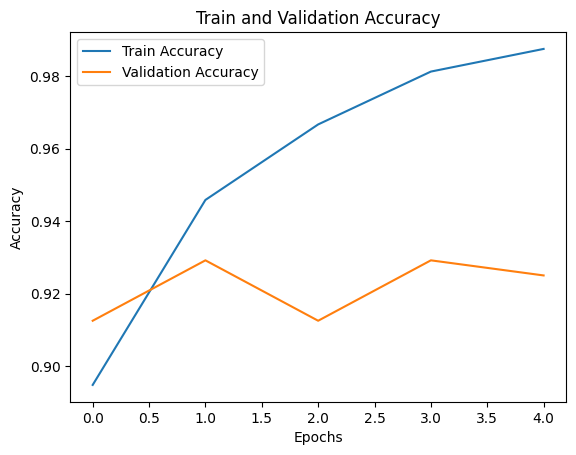

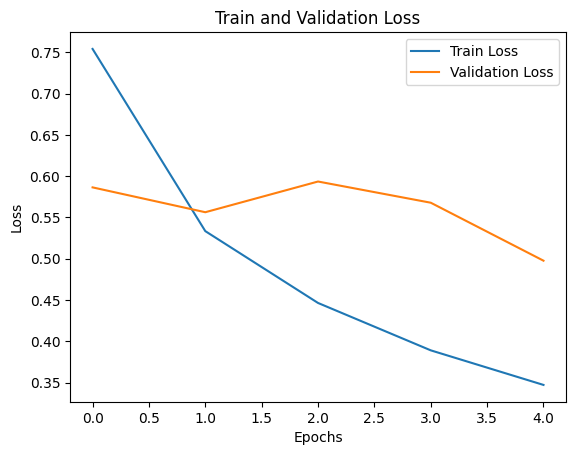

In [ ]:
# Afficher l'accuracy et la perte en fonction du nombre d'époques
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


Enregistrement du modèle entraîné, de son historique et des métriques dans des fichiers spécifiés.

In [ ]:
# Enregistrer le modèle
best_model.save('/content/drive/MyDrive/models/VGG16_finetuned_model.h5')

# Enregistrer l'historique
with open('/content/drive/MyDrive/models/VGG16_finetuned_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Enregistrer les métriques dans un fichier JSON
metrics_dict = {
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy']
}

with open('/content/drive/MyDrive/models/VGG16_finetuned_metrics.json', 'w') as json_file:
    json.dump(metrics_dict, json_file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
